### 注意力的多种不同形式

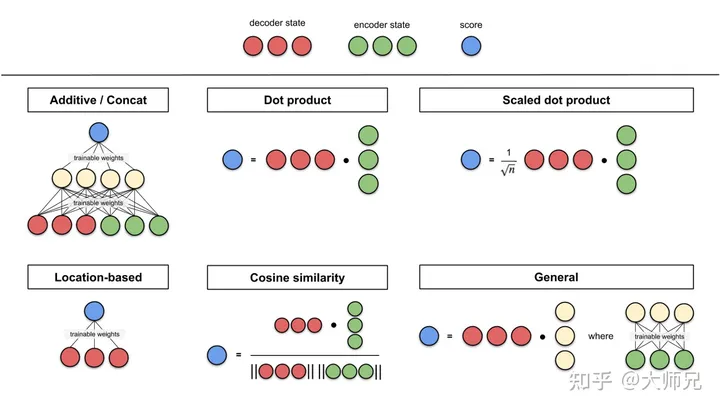

**注意力的本质就是为特征向量中每个特征计算一个权值**
既然这些不同的注意力机制均可以起到这个作用，那么我们也没必要将注意力计算的方式固定在缩放点乘注意力上。

1. Bahdanau等人提出的加性注意力（Additive Attention）或者拼接注意力（Concat Attention）
2. Transformer的缩放点乘注意力
3. 《Neural turing machines》中提出的cosin相似性注意力
4. 仅仅基于位置进行的注意力 location-based attention

#### 加性注意力

1. 计算注意力得分：
\begin{equation}
e_{ij} = \mathbf{v}^\top \tanh(\mathbf{W}_q \mathbf{q}_i + \mathbf{W}_k \mathbf{k}_j + \mathbf{b})
\end{equation}

1. 计算注意力权重：
\begin{equation}
\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{n} \exp(e_{ik})}
\end{equation}

1. 计算加权和：
\begin{equation}
\mathbf{c}_i = \sum_{j=1}^{n} \alpha_{ij} \mathbf{v}_j
\end{equation}

### AFT
注意力的本质就是为特征向量中每个特征计算一个权值，既然这些不同的注意力机制均可以起到这个作用，那么我们也没必要将注意力计算的方式固定在缩放点乘注意力上。只要我们能够以比Transformer更低的复杂度比较有效的计算出注意力权值，那么我们便可以解决缩放点乘自注意力带来的高复杂度问题。所以AFT最根本的原理便是如何设计一个高效的权值计算方式。AFT的论文中提出了四个不同的Attention Free的计算方式，分别是AFT-full，AFT-local，AFT-simple和AFT-conv，下面我们来分别介绍他们。

ref: https://zhuanlan.zhihu.com/p/680983091

#### AFT-full

![jupyter](/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/images/AFT-full.png)
![jupyter](/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/images/AFT2-full.png)


### AFT-local & AFT-simple
我们知道Transformer的复杂度是$O(T^2*d)$ ，从AFT-full的实现方式我们也可以看出AFT-full的复杂度也是 $O(T^2*d)$。
不同于Transformer的是，AFT-full的复杂度是因为$w$ 参与到计算中带来的，因此我们可以调整 $w$ 的样式来提升AFT的速度。

![jupyter](/Users/zhangxiaoyu/WorkSpace/rl/model_architecture/iamges/AFT-local-simple.png)


### AFT-conv
没太懂


AFT取名Attention Free其实并不严谨，因为它并没有抛弃注意力模块。更严格的说它是通过矩阵的逐元素乘法替代了Transformer的矩阵乘法。但是在实现时我们发现AFT的运算中仍然有计算矩阵乘法的步骤，不过它计算的矩阵从QK改成了 wQ，而 wQ的大小是还是取决于设置的句子的长度，因此算法的复杂度并没有降低，但是我们可以通过调整w的大小来一定程度上提升AFT的速度，这也就是为什么作者在这篇文章里提出AFT-full，AFT-local，AFT-simple和AFT-conv四个模型。不过AFT的设计思想还是很巧妙的，至于它的效果可能就需要更多的实验去验证.

In [ ]:
import torch, math
from torch import nn, einsum
import torch.nn.functional as F    

class AFTFull(nn.Module):
    def __init__(self, max_seqlen, dim, hidden_dim=64):
        super().__init__()
        '''
        max_seqlen: the maximum number of timesteps (sequence length) to be fed in
        dim: the embedding dimension of the tokens, set to d.
        hidden_dim: the hidden dimension used inside AFT Full, set to d.

        Number of heads is 1 as done in the paper
        '''
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)  # (d,d)
        self.to_k = nn.Linear(dim, hidden_dim)  # (d,d)
        self.to_v = nn.Linear(dim, hidden_dim)  # (d,d)
        self.project = nn.Linear(hidden_dim, dim)  # (d,d)
        self.wbias = nn.Parameter(torch.Tensor(max_seqlen, max_seqlen))  # (T, T)
        nn.init.xavier_uniform_(self.wbias)

    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)  # (B, T, d)
        K = self.to_k(x).view(B, T, self.hidden_dim)  # (B, T, d)
        V = self.to_v(x).view(B, T, self.hidden_dim)  # (B, T, d)
        temp_wbias = self.wbias[:T, :T].unsqueeze(0) # sequences can still be variable length

        '''
        From the paper，https://zhuanlan.zhihu.com/p/680983091，从向量形式转变为矩阵乘法的推导过程看博客内容，有公式推导。
        '''
        Q_sig = torch.sigmoid(Q)
        temp = torch.exp(temp_wbias) @ torch.mul(torch.exp(K), V)
        weighted = temp / (torch.exp(temp_wbias) @ torch.exp(K))
        Yt = torch.mul(Q_sig, weighted)

        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)

        return Yt

class AFTSimple(nn.Module):
    def __init__(self, max_seqlen, dim, hidden_dim=64):
        super().__init__()
        '''
        max_seqlen: the maximum number of timesteps (sequence length) to be fed in
        dim: the embedding dimension of the tokens
        hidden_dim: the hidden dimension used inside AFT Full
        
        Number of Heads is 1 as done in the paper.
        '''
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)
        self.to_k = nn.Linear(dim, hidden_dim)
        self.to_v = nn.Linear(dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)
        K = self.to_k(x).view(B, T, self.hidden_dim)
        V = self.to_v(x).view(B, T, self.hidden_dim)

        '''
        From the paper
        '''
        weights = torch.mul(torch.softmax(K, 1), V).sum(dim=1, keepdim=True)
        Q_sig = torch.sigmoid(Q)
        Yt = torch.mul(Q_sig, weights)

        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)

        return Yt

class AFTLocal(nn.Module):
    def __init__(self, max_seqlen, dim, hidden_dim=64, s=256):
        super().__init__()
        '''
        max_seqlen: the maximum number of timesteps (sequence length) to be fed in
        dim: the embedding dimension of the tokens
        hidden_dim: the hidden dimension used inside AFT Full
        s: the window size used for AFT-Local in the paper

        Number of heads is 1 as done in the paper
        '''
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)
        self.to_k = nn.Linear(dim, hidden_dim)
        self.to_v = nn.Linear(dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, dim)
        self.wbias = nn.Parameter(torch.Tensor(max_seqlen, max_seqlen))
        self.max_seqlen = max_seqlen
        self.s = s
        nn.init.xavier_uniform_(self.wbias)


    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)
        K = self.to_k(x).view(B, T, self.hidden_dim)
        V = self.to_v(x).view(B, T, self.hidden_dim)
        self.wbias = nn.Parameter(torch.Tensor([
            [self.wbias[i][j] if math.fabs(i-j) < self.s else 0 for j in range(self.max_seqlen)] 
            for i in range(self.max_seqlen)
            ]))
        temp_wbias = self.wbias[:T, :T].unsqueeze(0) # sequences can still be variable length

        '''
        From the paper
        '''
        Q_sig = torch.sigmoid(Q)
        temp = torch.exp(temp_wbias) @ torch.mul(torch.exp(K), V)
        weighted = temp / (torch.exp(temp_wbias) @ torch.exp(K))
        Yt = torch.mul(Q_sig, weighted)

        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)

        return Yt

class AFTConv(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        raise NotImplementedError

'''
Taken from the PyTorch docs for Positional Embeddings only
'''
# class PositionalEncoding(nn.Module):
#     def __init__(self, dim, p=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=p)

#         pe = torch.zeros(max_len, dim)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)

# class MLP(nn.Module):
#     def __init__(self, dim, hidden_dim, dp=0.1):
#         super().__init__()
#         self.l1 = nn.Linear(dim, hidden_dim)
#         self.g1 = nn.GELU()
#         self.l2 = nn.Linear(hidden_dim, dim)
#         self.d1 = nn.Dropout(dp)

#     def forward(self, x):
#         x = self.l1(x)
#         x = self.g1(x)
#         x = self.d1(x)
#         out = self.l2(x)

#         return out        

# class AFTEncoderBlock(nn.Module):
#     def __init__(self, dim, hidden_dim, p=0.1):
#         super().__init__()
#         self.ln = nn.LayerNorm(dim)
#         self.attn = AFTFull(dim, hidden_dim)
#         self.mlp = MLP(dim, hidden_dim)
#         self.d1 = nn.Dropout(p)
#         self.d2 = nn.Dropout(p)

#     def forward(self, x):
#         x = self.ln(x)
#         x = self.attn(x) + x
#         x = self.d1(x)
#         x = self.ln(x)
#         x = self.mlp(x)
#         out = self.d2(x) + x

#         return out

# class AFTDecoderBlock(nn.Module):
#     def __init__(self, dim, hidden_dim, p=0.1):
#         super().__init__()
#         self.ln = nn.LayerNorm(dim)
#         self.attn1 = AFTFull(dim, hidden_dim)
#         self.attn2 = AFTFull(dim, hidden_dim)
#         self.mlp = MLP(dim, hidden_dim, p=p)
#         self.d1 = nn.Dropout(p)
#         self.d2 = nn.Dropout(p)
#         self.d3 = nn.Dropout(p)

#     def forward(self, x):
#         x = self.ln(x)
#         x = self.attn1(x)
#         x = self.d1(x) + x
#         x = self.ln(x)
#         x = self.attn2(x)
#         x = self.dropout_2(x) + x
#         x = self.ln(x)
#         x = self.mlp(x)
#         out = self.d3(x) + x

#         return out

# class AFT(nn.Module):
#     def __init__(self, vocab_size, dim, hidden_dim, enc=None, dec=None, depth=6, p=0.1):
#         super().__init__()
#         self.layers = nn.ModuleList()
#         self.pos_embed = PositionalEncoding(dim, p=p)
#         self.embed = nn.Embedding(vocab_size, dim)
#         self.enc = enc if enc else nn.ModuleList([AFTEncoderBlock(dim, hidden_dim) for _ in range(depth)])
#         # self.dec = nn.ModuleList([AFTDecoderBlock(dim, hidden_dim) for _ in range(depth)])
#         self.dec = dec if dec else nn.Linear(dim, vocab_size)
#         self.dim = dim

#     def forward(self, x):
#         x = self.embed(x) * math.sqrt(self.dim)
#         print (x.shape)
#         x = self.pos_embed(x)
#         x = self.enc(x)
#         out = self.dec(x)

#         return out

In [ ]:
import torch, math
import numpy as np
from torch import nn, einsum
import torch.nn.functional as F    

class AFTFull(nn.Module):
    def __init__(self, max_seqlen=512, dim=768, hidden_dim=64):
        super().__init__()
        '''
        max_seqlen: the maximum number of timesteps (sequence length) to be fed in
        dim: the embedding dimension of the tokens, set to d.
        hidden_dim: the hidden dimension used inside AFT Full, set to d.

        Number of heads is 1 as done in the paper
        '''
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.to_q = nn.Linear(dim, hidden_dim)  # (768, 64)
        self.to_k = nn.Linear(dim, hidden_dim)  # (768, 64)
        self.to_v = nn.Linear(dim, hidden_dim)  # (768, 64)
        self.project = nn.Linear(hidden_dim, dim)  # (768, 64)
        self.wbias = nn.Parameter(torch.Tensor(max_seqlen, max_seqlen))  # (10, 10)
        nn.init.xavier_uniform_(self.wbias)

    def forward(self, x):
        B, T, _ = x.shape
        Q = self.to_q(x).view(B, T, self.hidden_dim)  # (10, 512, 64)
        K = self.to_k(x).view(B, T, self.hidden_dim)  # (10, 512, 64)
        V = self.to_v(x).view(B, T, self.hidden_dim)  # (10, 512, 64)
        temp_wbias = self.wbias[:T, :T].unsqueeze(0) # sequences can still be variable length  (1, 512, 512)

        '''
        From the paper
        '''
        Q_sig = torch.sigmoid(Q)  # (10, 512, 64)
        temp = torch.exp(temp_wbias) @ torch.mul(torch.exp(K), V)
        weighted = temp / (torch.exp(temp_wbias) @ torch.exp(K))
        Yt = torch.mul(Q_sig, weighted)

        Yt = Yt.view(B, T, self.hidden_dim)
        Yt = self.project(Yt)

        return Yt

torch.manual_seed(42)
x = torch.randn(10, 512, 768)
model = AFTFull()
y = model(x)

